# An analysis of sex ratios using a biodiversity data cube from GBIF data

This notebook was created for analysing GBIF download https://www.gbif.org/occurrence/download/0083528-240321170329656
Date 2 April 2024
Occurrences 4,038,527
Involved datasets 4,985
Involved publishers 230

Note: This select ignores ```dwc:individualCount``` in the record. It treats each record as an individual.
In the future it

``` SELECT "year", gbif_eeargCode(10000, decimalLatitude, decimalLongitude, COALESCE(coordinateUncertaintyInMeters, 10000)) AS eeaCellCode, speciesKey, COUNT(*) AS 'count', SUM(CASE WHEN sex = 'FEMALE' THEN 1 ELSE 0 END) AS female_count, SUM(CASE WHEN sex = 'MALE' THEN 1 ELSE 0 END) AS male_count, SUM(CASE WHEN sex = 'HERMERMAPHRODITE' THEN 1 ELSE 0 END) AS hermaphrodite_count, MIN(COALESCE(coordinateUncertaintyInMeters, 10000)) AS minCoordinateUncertaintyInMeters FROM occurrence WHERE occurrenceStatus = 'PRESENT' AND familyKey = 2986 AND NOT array_contains(issue, 'ZERO_COORDINATE') AND NOT array_contains(issue, 'COORDINATE_OUT_OF_RANGE') AND NOT array_contains(issue, 'COORDINATE_INVALID') AND NOT array_contains(issue, 'COUNTRY_COORDINATE_MISMATCH') AND (identificationVerificationStatus IS NULL OR NOT ( LOWER(identificationVerificationStatus) LIKE '%unverified%' OR LOWER(identificationVerificationStatus) LIKE '%unvalidated%' OR LOWER(identificationVerificationStatus) LIKE '%not able to validate%' OR LOWER(identificationVerificationStatus) LIKE '%control could not be conclusive due to insufficient knowledge%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed - not reviewed%' OR LOWER(identificationVerificationStatus) LIKE '%validation requested%' ) ) AND "year" >= 1900 AND continent = 'EUROPE' AND hasCoordinate GROUP BY "year", eeaCellCode, speciesKey ORDER BY "year" DESC, eeaCellCode ASC, speciesKey ASC; ```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import seaborn as sns
from shapely.geometry import Polygon, MultiPolygon
import requests
import sys
import scipy.stats as stats
from pykrige.ok import OrdinaryKriging
from matplotlib.path import Path

Read the file, assuming it's tab-separated and the first row contains column names

In [2]:
file_path = '0083528-240321170329656.csv'   
df = pd.read_csv(file_path, sep='\t')

#### Split the 'eeacellcode' column into three new columns ('resolution', 'long', 'lat')
    with four characters in each and adds them to the DataFrame.

    Parameters:
    - df: The original DataFrame containing the 'eeacellcode' column.

    Returns:
    - df: The modified DataFrame with the new columns added.
    """
#### Check if 'eeacellcode' column exists in the DataFrame

In [3]:
if 'eeacellcode' in df.columns:
     # Splitting the 'eeacellcode' column into three new columns
     df['resolution'] = df['eeacellcode'].str[:4]
     df['long'] = df['eeacellcode'].str[4:8]
     df['lat'] = df['eeacellcode'].str[8:12]
else:
     print("The column 'eeacellcode' does not exist in the DataFrame.")

#### Drop some rows with blanks in them

In [4]:
df = df.dropna()

#### Remove the first character from 'long' and 'lat' columns and create new 'longitude' and 'latitude' columns

In [5]:
df['longitude'] = df['long'].str[1:]

In [6]:
df['latitude'] = df['lat'].str[1:]

In [7]:
df['longitude'] = pd.to_numeric(df['longitude'], downcast='float') * 10000
df['latitude'] = pd.to_numeric(df['latitude'], downcast='float') * 10000

#### Convert 'longitude' and 'latitude' to numeric types, if they're not already

In [8]:
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

#### Create a new GeoDataFrame

In [9]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

#### Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude

In [10]:
gdf.crs = "EPSG:3035"

# Now 'gdf' is a GeoDataFrame with a 'geometry' column holding spatial data

# Print out a few rows, just to check that everything looks okay.
print(gdf.head(2))

    year   eeacellcode  specieskey  count  female_count  male_count  \
25  2024  10kmE263N192   8332393.0      1             0           0   
26  2024  10kmE263N195   9751099.0      1             0           0   

    hermaphrodite_count  mincoordinateuncertaintyinmeters resolution  long  \
25                    0                           28240.0       10km  E263   
26                    0                           10000.0       10km  E263   

     lat  longitude   latitude                         geometry  
25  N192  2630000.0  1920000.0  POINT (2630000.000 1920000.000)  
26  N195  2630000.0  1950000.0  POINT (2630000.000 1950000.000)  


#### Plot of all the points to check that the it meets expectations

This has been commented out as it takes a while to run, and is really only useful for debugging purposes.

In [11]:
#gdf.plot(marker='o', color='red', markersize=1)
#plt.show()

#### Group by 'specieskey' and aggregate the counts
The geometry is not directly involved in the aggregation here

In [12]:
result = gdf.groupby('specieskey').agg({
    'count': 'sum',  # Summing up total counts
    'female_count': 'sum',  # Summing up female counts
    'male_count': 'sum',    # Summing up male counts
}).reset_index()

# Now sort the results by 'count' in descending order just to get a look at which are commonest and which are rarest
result = result.sort_values(by='count', ascending=False)

#### Define a function to get species Latin name from GBIF by speciesKey

In [13]:
def get_species_names(speciesKey):
    # Convert speciesKey to integer to remove the '.0'
    speciesKey = int(speciesKey)
    url = f"https://api.gbif.org/v1/species/{speciesKey}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        latin_name = data.get('scientificName')
        vernacular_name = data.get('vernacularName', 'N/A')  # Default to 'N/A' if not available
        return latin_name, vernacular_name
    else:
        print(f"Failed to retrieve data for speciesKey {speciesKey}. Status code: {response.status_code}")
        return None, None

#### Function to append Latin names to your DataFrame

In [14]:
def append_names(df):
    # Create new columns for the Latin and vernacular names
    names = df['specieskey'].apply(lambda x: get_species_names(x))
    df['latin_name'] = names.apply(lambda x: x[0])
    df['vernacular_name'] = names.apply(lambda x: x[1])
    return df

#### Calculate the proportion for each row of the number of records with a sex vs the total count

In [15]:
result['proportion'] = (result['female_count'] + result['male_count']) / result['count']

# Then, find the row with the maximum proportion
max_prop_row = result.loc[result['proportion'].idxmax()]
min_prop_row = result.loc[result['proportion'].idxmin()]
max_species = get_species_names(max_prop_row['specieskey'])
min_species = get_species_names(min_prop_row['specieskey'])

# Print out the specieskey and the maximum proportion
print(f"Species Key with highest proportion: {max_prop_row['specieskey']}")
print(f"Species name: {max_species}")
print(f"Maximum proportion: {max_prop_row['proportion']}")

print(f"Species Key with lowest proportion: {min_prop_row['specieskey']}")
print(f"Species name: {min_species}")
print(f"Minimum proportion: {min_prop_row['proportion']}")

Species Key with highest proportion: 2498183.0
Species name: ('Asarcornis scutulata (S.Müller, 1842)', 'White-winged Duck')
Maximum proportion: 1.0
Species Key with lowest proportion: 2498263.0
Species name: ('Aythya americana (Eyton, 1838)', 'Redhead')
Minimum proportion: 0.0


##### Sort the DataFrame by the 'proportion' column in descending order

Filter the DataFrame to include only rows where 'count' > 10000

10000 is a rather arbitary number to filter our rare and casual species

In [16]:
sorted_gdf = result.sort_values(by='proportion', ascending=False)

filtered_result = sorted_gdf[sorted_gdf['count'] > 10000].copy()

filtered_result_with_names = append_names(filtered_result)

# Step 2: Select the top ten entries
top_ = filtered_result.head(5).copy()

# Step 3: Select the bottom ten entries
bottom_ = filtered_result.sort_values(by='proportion', ascending=True).head(5).copy()

# Apply the function to both top ten and bottom ten DataFrames
top_ten_with_names = append_names(top_)
bottom_ten_with_names = append_names(bottom_)

#### Display the results

In [17]:
print("Top species by proportion:")
print(top_[['specieskey', 'count', 'proportion', 'latin_name', 'vernacular_name']])

print("\nBottom species by proportion:")
print(bottom_[['specieskey', 'count', 'proportion', 'latin_name', 'vernacular_name']])

Top species by proportion:
     specieskey  count  proportion                              latin_name  \
82    2498350.0  33654    0.488649  Somateria spectabilis (Linnaeus, 1758)   
105   5232431.0  11861    0.405278      Polysticta stelleri (Pallas, 1769)   
33    2498125.0  11056    0.374457      Anas carolinensis J.F.Gmelin, 1789   
36    2498155.0  10457    0.281534     Mareca americana (J.F.Gmelin, 1789)   
60    2498264.0  20277    0.266854         Aythya collaris (Donovan, 1809)   

       vernacular_name  
82          King Eider  
105    Steller's Eider  
33   Green-winged Teal  
36     American Wigeon  
60    Ring-necked Duck  

Bottom species by proportion:
     specieskey   count  proportion                           latin_name  \
10    2498024.0  269082    0.000691   Anser brachyrhynchus Baillon, 1834   
111   5232451.0   45531    0.000857     Branta ruficollis (Pallas, 1769)   
40    2498167.0   22508    0.001066  Anser caerulescens (Linnaeus, 1758)   
158  10124612.0   1

In [18]:
num_rows = len(filtered_result)
print("Number of species left:", num_rows)
filtered_result_with_names.to_csv('high_species_counts.csv', index=False)

Number of species left: 54


#### Calculate the start year of the decade for each row and create a new 'decade' column

In [19]:
gdf['decade'] = (gdf['year'] // 10) * 10

#### Convert the geometrycolumn to well known text sothat it can be aggregated in the next step

In [20]:
gdf['geometry_wkt'] = gdf['geometry'].apply(lambda x: x.wkt)

#### Grouping the DataFrame by 'eeacellcode' and 'specieskey'

In [21]:
grouped_df = gdf.groupby(['decade','eeacellcode', 'specieskey', 'long', 'lat', 'longitude', 'latitude','geometry_wkt'])[['count', 'female_count', 'male_count']].sum().reset_index()

#### Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude

In [22]:
grouped_df.crs = "EPSG:3035"

In [23]:
grouped_df['geometry'] = grouped_df['geometry_wkt'].apply(wkt.loads)

# Convert to a GeoDataFrame
ggdf = gpd.GeoDataFrame(grouped_df, geometry='geometry')

## Choose a species of European duck  to analyses

#### An example is *Aythya fuligula* (L., 1758) = 2498261 (Tufted Duck) a freshwater duck
#### Another is *Somateria mollissima* (Linnaeus, 1758) = 2498352 (Common Eider) a sea duck
#### And yet another is *Somateria spectabilis* (Linnaeus, 1758) = 2498350 (King Eider) a sea duck


In [24]:
duckkey = input("Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): ")

# Check if the input is empty
if not duckkey.strip():
    # Set default value if input is empty
    duckkey = 9761484
    
duckkey = int(duckkey)

print(f"Your duck key is , {duckkey}!")

Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): 2498352
Your duck key is , 2498352!


#### Select rows where the 'specieskey' column matches the specific_specieskey

In [25]:
filtered_gdf = ggdf[ggdf['specieskey'] == duckkey].copy()

##### Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude

In [26]:
filtered_gdf.crs = "EPSG:3035"

In [27]:
columns = grouped_df.columns
print(columns)

Index(['decade', 'eeacellcode', 'specieskey', 'long', 'lat', 'longitude',
       'latitude', 'geometry_wkt', 'count', 'female_count', 'male_count',
       'geometry'],
      dtype='object')


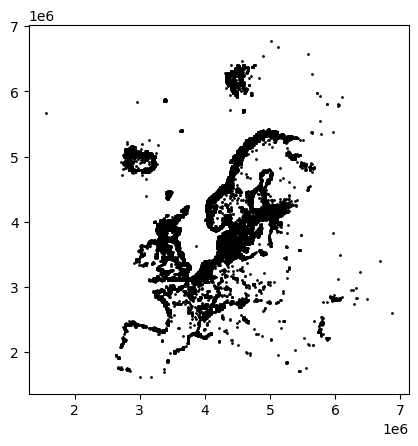

In [28]:
filtered_gdf.plot(marker='o', color='black', markersize=1)
plt.show()

#### Remove rows where both 'female_count' and 'male_count' are zero, and 'eeacellcode' is NaN

In [29]:
filtered_gdf1 = filtered_gdf[(filtered_gdf['female_count'] > 1) | (filtered_gdf['male_count'] > 1)]

In [30]:
filtered_gdf.loc[:, 'percentage_male'] = np.where(
    (filtered_gdf['female_count'] + filtered_gdf['male_count']) > 0,
    100 * (filtered_gdf['male_count'] / (filtered_gdf['female_count'] + filtered_gdf['male_count'])),
    np.nan
)


#### Plot using the 'sex_ratio' column to color the points

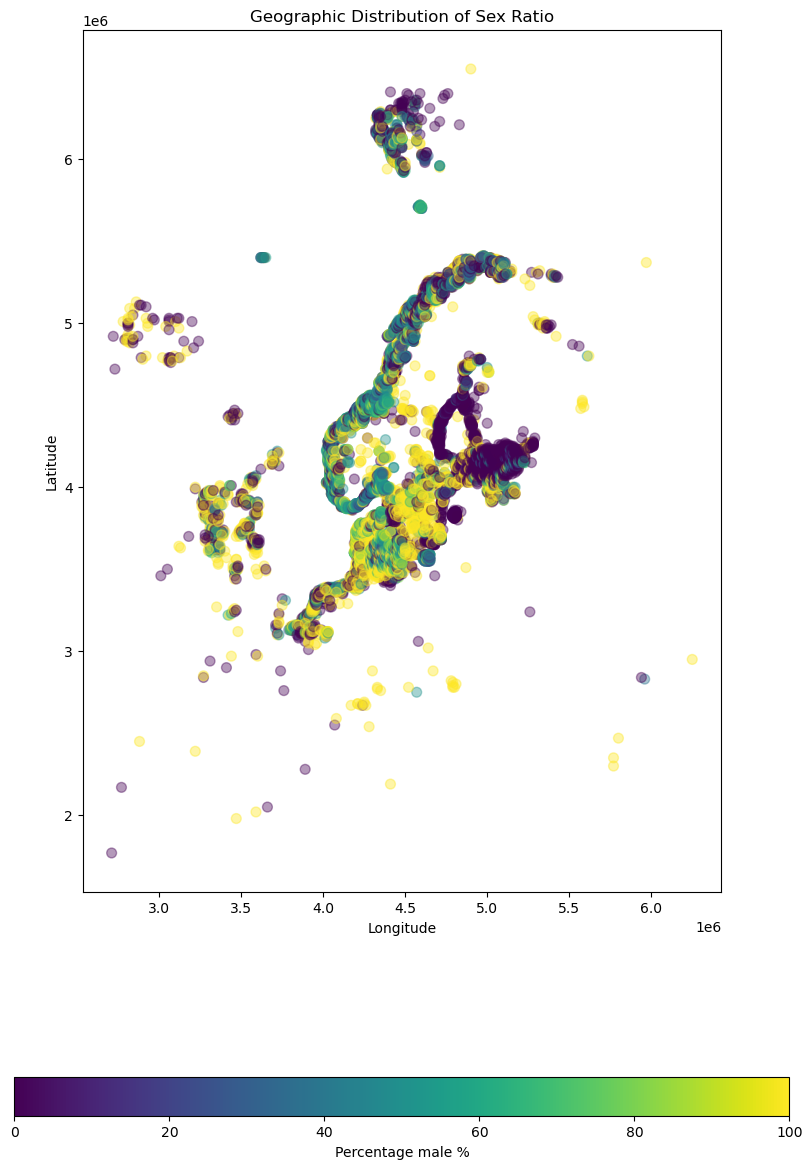

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

filtered_gdf.plot(column='percentage_male', ax=ax, legend=True, 
         legend_kwds={'label': "Percentage male %", 'orientation': "horizontal"},
         cmap='viridis', markersize=50, alpha=0.4)  # Adjust 'markersize' and 'alpha' as needed

plt.title('Geographic Distribution of Sex Ratio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [32]:
point_filtered_gdf = filtered_gdf.copy()

#### Drop NaN values and also ensure there are no infinite values

In [33]:
filtered_gdf = filtered_gdf.dropna(subset=['decade', 'percentage_male'])
filtered_gdf = filtered_gdf.replace([np.inf, -np.inf], np.nan).dropna(subset=['decade', 'percentage_male'])

# Filter cells with more than 10 observations
filtered_gdf = filtered_gdf[filtered_gdf['count'] > 10]

In [34]:
filtered_gdf.head()

,decade,eeacellcode,specieskey,long,lat,longitude,latitude,geometry_wkt,count,female_count,male_count,geometry,percentage_male
1714,1900,10kmE449N361,2498352.0,E449,N361,4490000.0,3610000.0,POINT (4490000 3610000),12,1,0,POINT (4490000.000 3610000.000),0.0
6049,1920,10kmE483N415,2498352.0,E483,N415,4830000.0,4150000.0,POINT (4830000 4150000),30,23,0,POINT (4830000.000 4150000.000),0.0
8057,1930,10kmE483N415,2498352.0,E483,N415,4830000.0,4150000.0,POINT (4830000 4150000),23,16,0,POINT (4830000.000 4150000.000),0.0
10119,1940,10kmE480N383,2498352.0,E480,N383,4800000.0,3830000.0,POINT (4800000 3830000),14,3,0,POINT (4800000.000 3830000.000),0.0
10121,1940,10kmE480N384,2498352.0,E480,N384,4800000.0,3840000.0,POINT (4800000 3840000),21,10,0,POINT (4800000.000 3840000.000),0.0


## The change in the percentage of male ducks aross Europe aggregated by decade

<Figure size 1200x600 with 0 Axes>

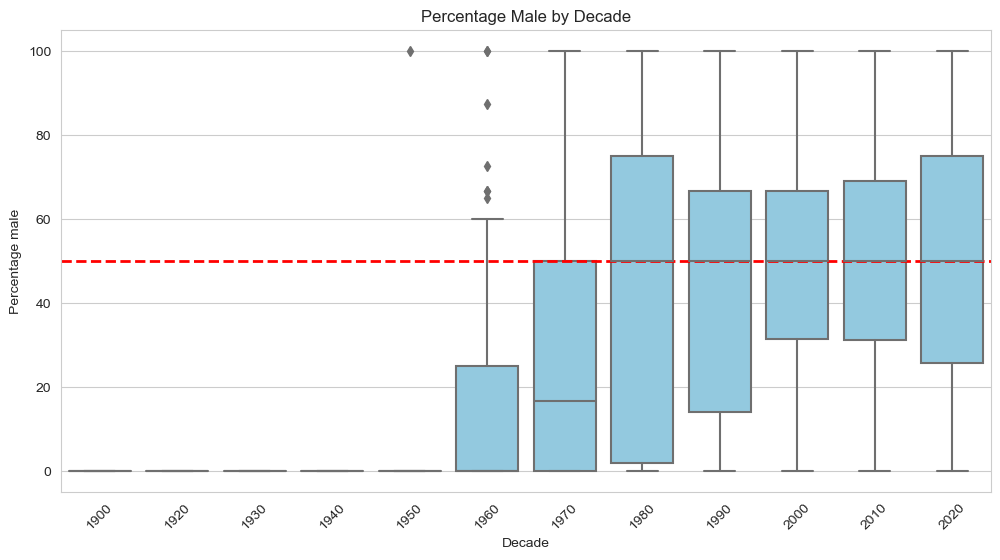

In [35]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='decade', y='percentage_male', data=filtered_gdf, color='skyblue', ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('linear')

# Adding a dotted horizontal line at 50%
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% line')

plt.title('Percentage Male by Decade')
plt.xlabel('Decade')
plt.ylabel('Percentage male')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.savefig('ratiotimeseries.jpg', dpi=600, format='jpg')
plt.show()


## The change in the total number of occupied cells per decade

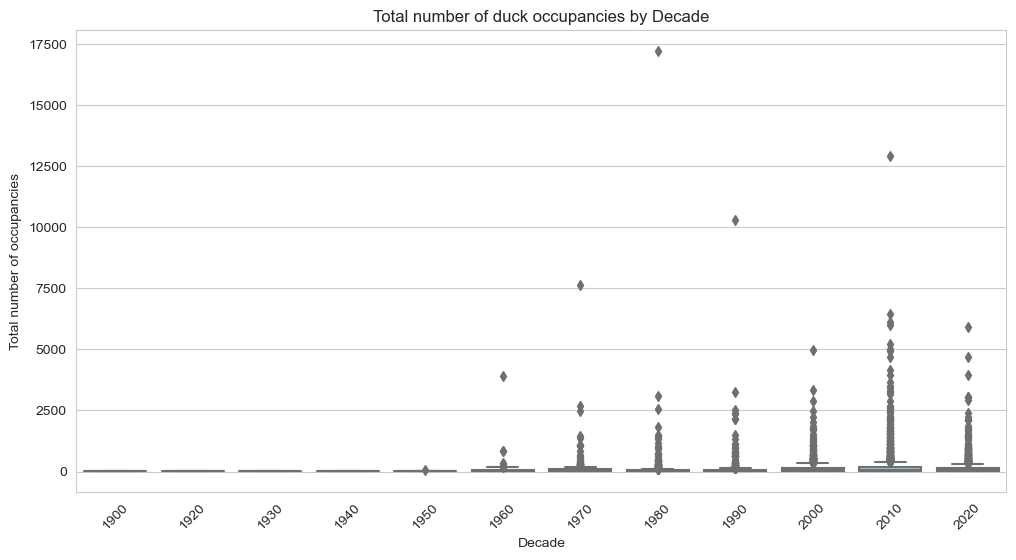

In [36]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='decade', y='count', data=filtered_gdf, color='skyblue')

plt.title('Total number of duck occupancies by Decade')
plt.xlabel('Decade')
plt.ylabel('Total number of occupancies')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()


#### Convert GeoDataFrame to a regular DataFrame for the melting process

In [37]:
df = pd.DataFrame(gdf.drop(columns='geometry'))

aggregatedAllByDecade = df.groupby('decade')[['male_count', 'female_count']].sum().reset_index()

# Melting the DataFrame
df_melted = aggregatedAllByDecade.melt(id_vars=['decade'], value_vars=['male_count', 'female_count'],
                    var_name='Gender', value_name='Count')

In [38]:
# Define a colorblind-safe palette
colors = sns.color_palette("Paired", 2)  # 'husl' is colorblind safe; adjust the number as needed for categories

#### Creating the boxplot with seaborn

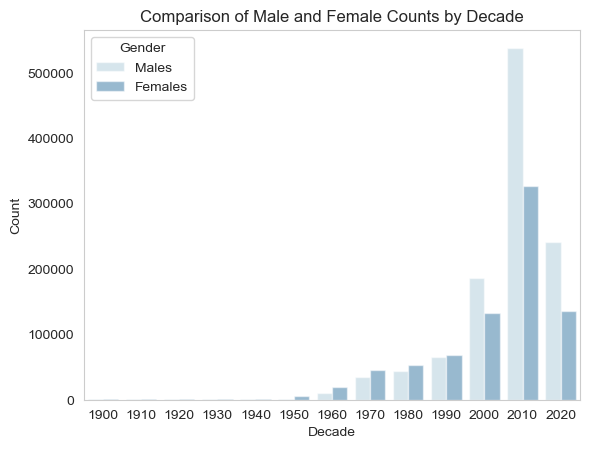

In [39]:
barplot = sns.barplot(x='decade', y='Count', hue='Gender', palette=colors, alpha=0.5, data=df_melted)

plt.title('Comparison of Male and Female Counts by Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.grid(axis='y')

# Modify the legend
leg = barplot.get_legend()
leg.set_title('Gender')
new_labels = ['Males', 'Females']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig('count.jpg', dpi=600, format='jpg')

plt.show()

Until this point the grid cells have been treated as points.
This function converts those points into square polygons.
This function defaults to 10x10 km grid cells. 

In [40]:
def create_square_polygon_from_point(point, side_length=10000):
    if point is None:
        return None
    lower_left = point
    lower_right = (point.x + side_length, point.y)
    upper_right = (point.x + side_length, point.y + side_length)
    upper_left = (point.x, point.y + side_length)
    return Polygon([lower_left, lower_right, upper_right, upper_left, lower_left])

#### Apply the function to create a new 'square_polygon' column

In [41]:
filtered_gdf['square_polygon'] = filtered_gdf['geometry'].apply(create_square_polygon_from_point)

In [42]:
filtered_gdf = filtered_gdf.set_geometry('square_polygon')

### Load the world country boundaries map
#### Country boundaries from https://www.naturalearthdata.com/downloads/50m-cultural-vectors/

In [43]:
path_to_shapefile = 'ne_50m_admin_0_countries.shp'

# Reading the shapefile
world = gpd.read_file(path_to_shapefile)

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['CONTINENT'] == 'Europe']
europe = europe.to_crs(filtered_gdf.crs)

#### Set the boundaries of the map. These can be replaced to zoom into specific areas.

In [44]:
min_longitude, max_longitude = 2500000, 6000000  # Adjust these values to your desired longitude bounds
min_latitude, max_latitude = 1500000, 6000000    # Adjust these values to your desired latitude bounds

#### Plot a map of of the records to show their distribtion

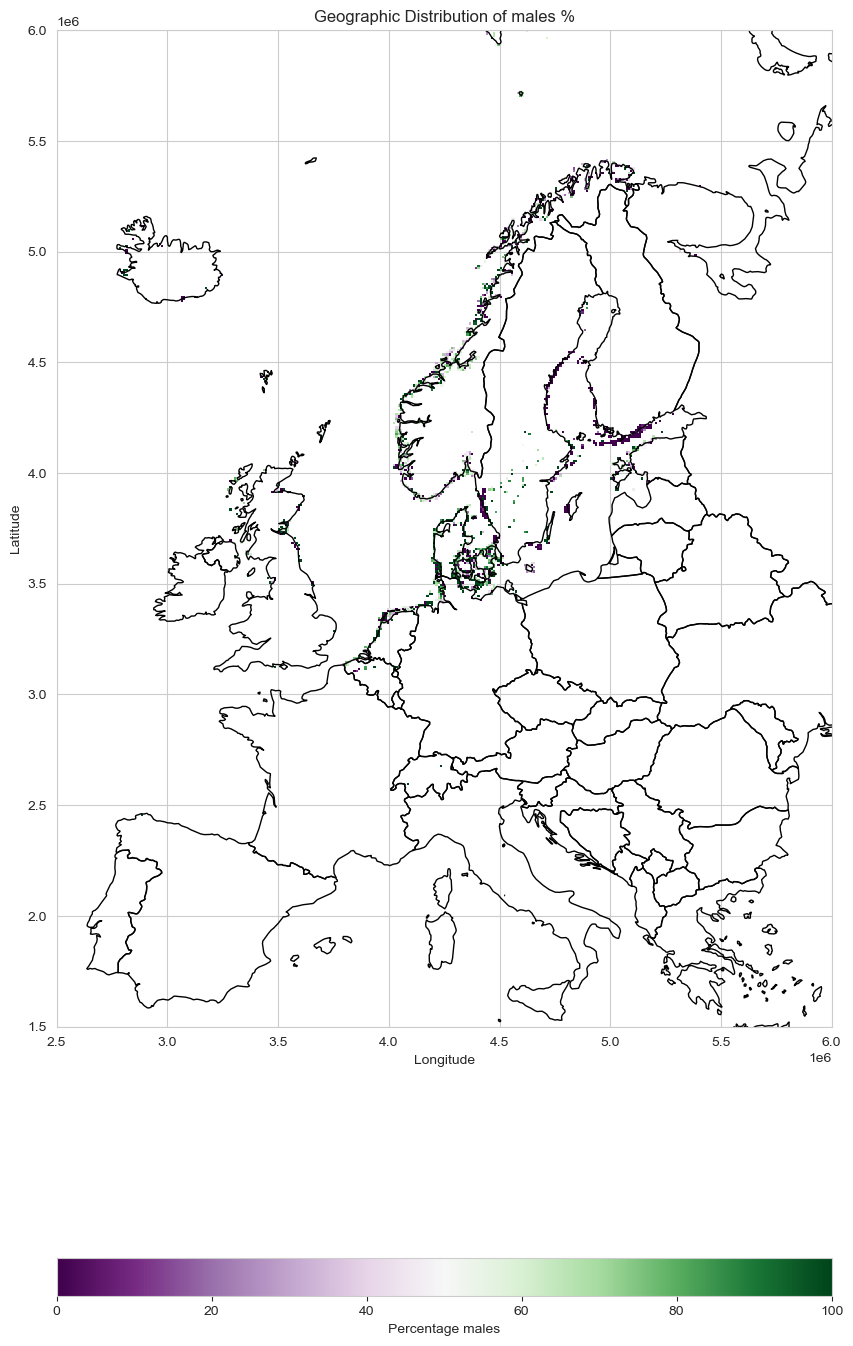

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

# Plot using the 'sex_ratio' column to color the points
filtered_gdf.plot(edgecolor='none', column='percentage_male', ax=ax, legend=True, 
         legend_kwds={'label': "Percentage males", 'orientation': "horizontal"},
         cmap='PRGn', markersize=50, alpha=1)  # Adjust 'markersize' and 'alpha' as needed
europe.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Set the x and y limits to your desired bounds
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

plt.title('Geographic Distribution of males %')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as a JPG file with 600 DPI (dots per inch), which is equivalent to PPI (pixels per inch)
plt.savefig('duckmap.jpg', dpi=600, format='jpg')

plt.show()

### Owing to the spatial hetrogenecity of the desisty of occupied grid cells it is useful to use kriging to interpolate between points and visulize possible structure in the data

Filtered Coordinates: [[4490000. 3610000.]
 [4830000. 4150000.]
 [4830000. 4150000.]
 ...
 [5190000. 4160000.]
 [5200000. 4150000.]
 [5380000. 4980000.]]
Filtered Values: [ 0.          0.          0.         ... 66.66666667 25.
  0.        ]
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'hole-effect' Variogram Model
Partial Sill: 965.7680406771593
Full Sill: 1038.8181690904441
Range: 1310158.1118449313
Nugget: 73.05012841328474 



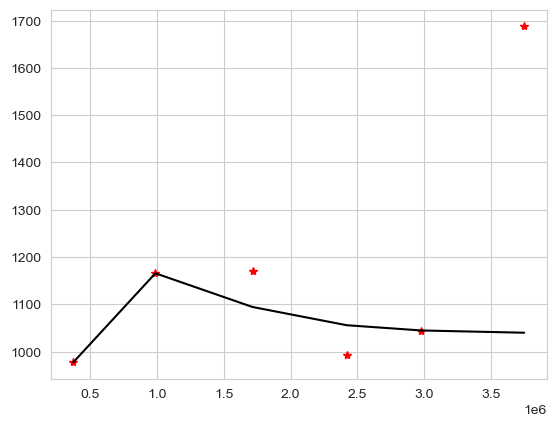

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



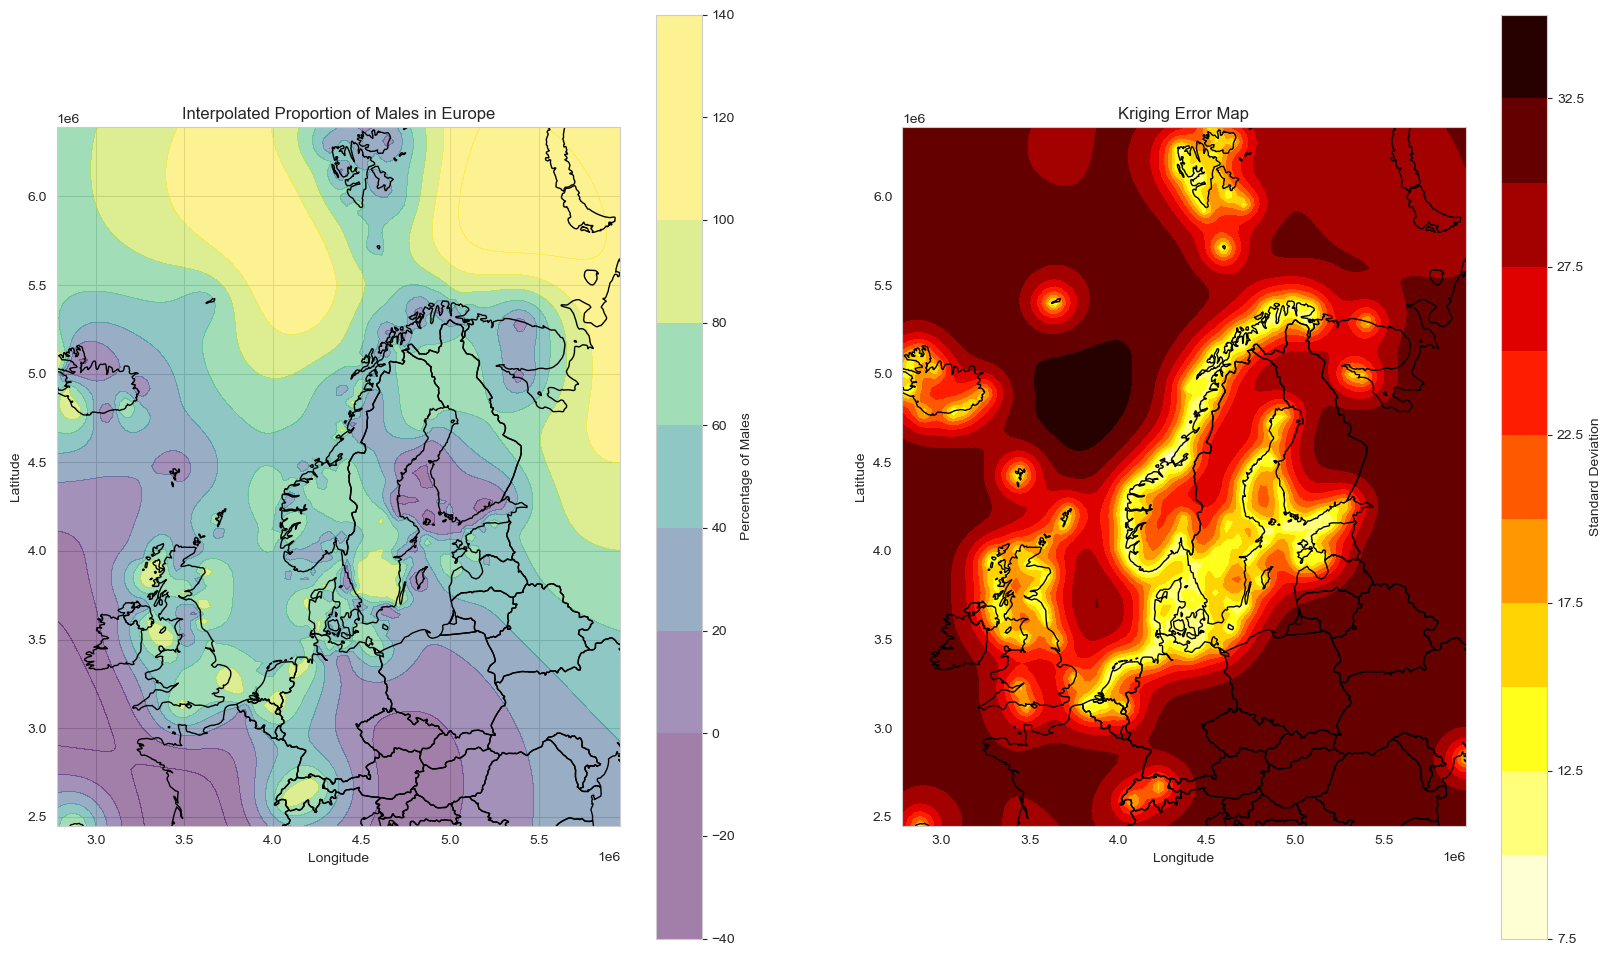

In [46]:
# Ensure your data has been correctly filtered and coordinates extracted
filtered = point_filtered_gdf[point_filtered_gdf['count'] > 10]

coordinates = np.array(list(filtered.geometry.apply(lambda geom: (geom.x, geom.y))))
values = filtered['percentage_male'].values

# Create a mask to identify non-NaN values
mask = ~np.isnan(values)

# Filter the coordinates and values arrays using the mask
filtered_coordinates = coordinates[mask]
filtered_values = values[mask]

# Check the filtered coordinates and values
print("Filtered Coordinates:", filtered_coordinates)
print("Filtered Values:", filtered_values)

# Create an Ordinary Kriging object with parameters
OK = OrdinaryKriging(
    filtered_coordinates[:, 0],  # X coordinates
    filtered_coordinates[:, 1],  # Y coordinates
    filtered_values,             # Data values
    #variogram_model='exponential',  # Example variogram model
    variogram_model='hole-effect',  # Example variogram model
    #variogram_model='linear',  # Example variogram model
    #variogram_model='dpherical',  # Example variogram model
    #variogram_model='power',  # Example variogram model
    #variogram_model='gaussian',  # Example variogram model
    verbose=True,       # For verbose output
    enable_plotting=True # For displaying variogram
)

# Define the grid size over which to interpolate
grid_x = np.linspace(filtered_coordinates[:, 0].min(), filtered_coordinates[:, 0].max(), num=100)
grid_y = np.linspace(filtered_coordinates[:, 1].min(), filtered_coordinates[:, 1].max(), num=100)

# Perform kriging to interpolate
z, ss = OK.execute('grid', grid_x, grid_y)

# Create a meshgrid for plotting
X, Y = np.meshgrid(grid_x, grid_y)

# Plot interpolated data and kriging error
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Plot interpolated data
cf1 = ax1.contourf(X, Y, z, cmap='viridis', alpha=0.5, levels=10, vmin=0, vmax=100)
fig.colorbar(cf1, ax=ax1, label='Percentage of Males')
europe.boundary.plot(ax=ax1, linewidth=1, edgecolor='k')
ax1.set_title('Interpolated Proportion of Males in Europe')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect('equal')

# Plot the error (standard deviation)
cf2 = ax2.contourf(X, Y, np.sqrt(ss), cmap='hot_r', levels=10)
fig.colorbar(cf2, ax=ax2, label='Standard Deviation')
europe.boundary.plot(ax=ax2, linewidth=1, edgecolor='k')
ax2.set_title('Kriging Error Map')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_aspect('equal')

# Set axis limits
ax1.set_xlim([X.min(), X.max()])
ax1.set_ylim([Y.min(), Y.max()])
ax2.set_xlim([X.min(), X.max()])
ax2.set_ylim([Y.min(), Y.max()])

# Save and show the plot
plt.savefig('european_males_interpolation_and_error.jpg', dpi=600, format='jpg')
plt.show()

### Ducks often tend to live in freshwater, or seawater, but not both. For this reason it can be useful to either crop out the land or the sea

To switch it over comment out the mask inversion and uncomment the mask lines


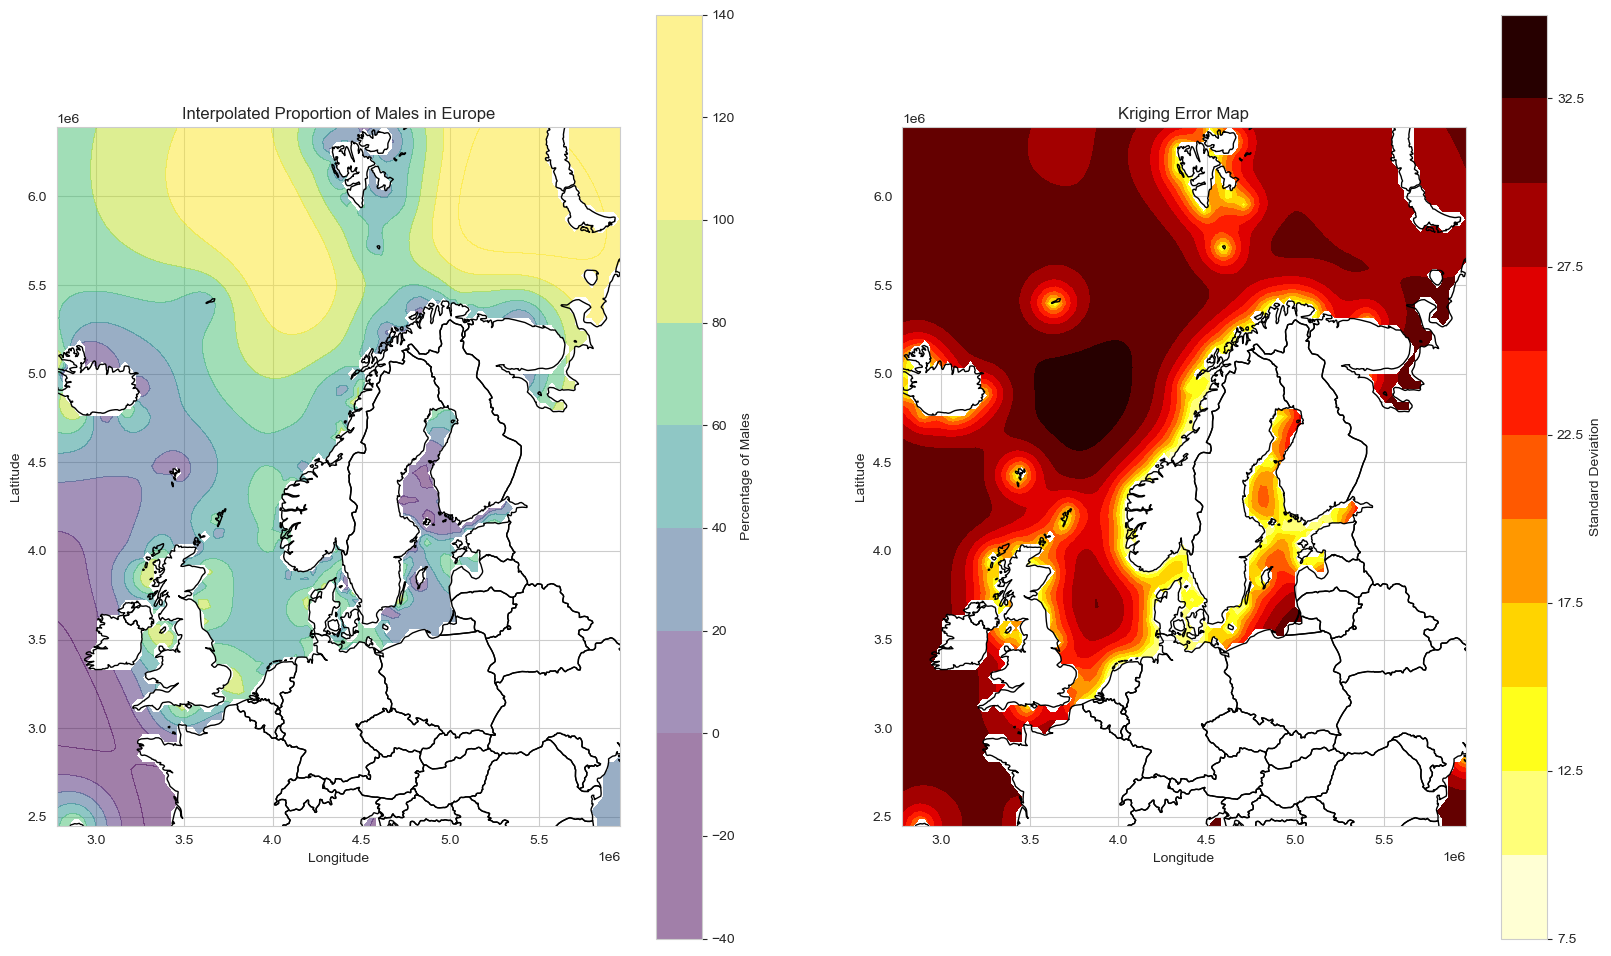

In [47]:
# Load the world country boundaries map
path_to_shapefile = 'ne_50m_admin_0_countries.shp'
world = gpd.read_file(path_to_shapefile)
europe = world[world['CONTINENT'] == 'Europe']
europe = europe.to_crs(filtered_gdf.crs)

# Extract the boundary of Europe
europe_boundary = europe.unary_union

# Initialize the list to hold boundary paths
boundary_paths = []

# Handle both Polygon and MultiPolygon cases
if isinstance(europe_boundary, Polygon):
    boundary_paths.append(Path(np.array(europe_boundary.exterior.coords)))
elif isinstance(europe_boundary, MultiPolygon):
    for poly in europe_boundary.geoms:  # .geoms allows iterating over the individual Polygons in the MultiPolygon
        boundary_paths.append(Path(np.array(poly.exterior.coords)))

# Create a mask based on whether each point in the grid is within the boundary
mask = np.zeros(X.shape, dtype=bool)
for boundary_path in boundary_paths:
    mask |= np.array([boundary_path.contains_point(point) for point in np.c_[X.ravel(), Y.ravel()]]).reshape(X.shape)

# Invert the mask
inverted_mask = ~mask

# Mask the kriging output with the inverted mask
z_masked = np.ma.masked_where(~inverted_mask, z)
ss_masked = np.ma.masked_where(~inverted_mask, ss)

# Mask the kriging output
#z_masked = np.ma.masked_where(~mask, z)
#ss_masked = np.ma.masked_where(~mask, ss)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Plot interpolated data with the mask applied
cf1 = ax1.contourf(X, Y, z_masked, cmap='viridis', alpha=0.5, levels=10, vmin=0, vmax=100)
fig.colorbar(cf1, ax=ax1, label='Percentage of Males')
europe.boundary.plot(ax=ax1, linewidth=1, edgecolor='k')
ax1.set_title('Interpolated Proportion of Males in Europe')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect('equal')

# Plot the error (standard deviation) with the mask applied
cf2 = ax2.contourf(X, Y, np.sqrt(ss_masked), cmap='hot_r', levels=10)
fig.colorbar(cf2, ax=ax2, label='Standard Deviation')
europe.boundary.plot(ax=ax2, linewidth=1, edgecolor='k')
ax2.set_title('Kriging Error Map')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_aspect('equal')

# Set axis limits
ax1.set_xlim([X.min(), X.max()])
ax1.set_ylim([Y.min(), Y.max()])
ax2.set_xlim([X.min(), X.max()])
ax2.set_ylim([Y.min(), Y.max()])

# Save and show the plot
plt.savefig('european_males_interpolation_and_error_cropped.jpg', dpi=600, format='jpg')
plt.show()
